# Дембицкий М.Е. ДЗ № 5

## Оглавление
[Задание 1](#task1)  
[Задание 2](#task2)  
[Задание 3](#task3)  
[Задание 4](#task4)  
[Задание 5](#task5)  

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

**Подгрузка библиотек и данных**

In [92]:
# Подгрузим библиотеки

import pandas as pd
import numpy as np

# Метрики
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
classification_report, precision_recall_curve, confusion_matrix

# Модели
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


**Разбиваем данные и готовимся к их предобработке**

In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [25]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [26]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [27]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

<a name="task1"></a>
### Задание 1 

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [28]:
# Цикл, трансформирующий каждый признак и закидывающий его в список
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standart', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [29]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

**Модели**

Я буду использовать 3 модели: Random Forest, Logistic Regression и LightGBM

In [30]:
log_classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

random_forest_classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

lgbm_classifier = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42)),
])

classifier_list = [lgbm_classifier, log_classifier, random_forest_classifier]

Обучим модель

In [31]:
#обучим наши модели
for model in classifier_list:
   model.fit(X_train, y_train)

In [32]:
#Инициализируем словарь models_preds, куда поместим наши прогнозы для тестовой выборки
models_preds = {}

for model in classifier_list:
    models_preds[model[1]] = model.predict_proba(X_test)[:, 1]


Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [40]:
data = []

for k, v in  models_preds.items():
    precision, recall, thresholds = precision_recall_curve(y_test, v)
    fscore = 2 * (precision * recall) / (precision + recall)
    ix = np.argmax(fscore)

    print(f'{k}:', 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]
                                                                            ))

    metrics_data = [precision[ix], recall[ix], fscore[ix]]
    data.append(metrics_data)

LGBMClassifier(random_state=42): Best Threshold=0.371377, F-Score=0.653, Precision=0.661, Recall=0.646
LogisticRegression(random_state=42): Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
RandomForestClassifier(random_state=42): Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


<a name="task2"></a>
### Задание 2

Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

**Смотрим, какая модель показывает сеюя лучше на даный момент**

In [41]:
cols = ['precision', 'recall', 'fscore']
rows = ['lgbm_classifier', 'log_classifier', 'random_forest_classifier']

concl = pd.DataFrame(data, rows, cols)
concl


,precision,recall,fscore
lgbm_classifier,0.660643,0.646365,0.653426
log_classifier,0.462400,0.567780,0.509700
random_forest_classifier,0.654397,0.628684,0.641283


На данный момент лучший результат показывает LGBMClassifier, однако даже так, скор весьма и весьма скромный. Касательно того, какая метрика более уместна - мне кажется что это будет f1_score, так как она представляет собой гармоническое среднее между 	precision и recall, дабы не попасть в ситуацию, когда одна метрика высока, а по второй мы в полном пролете, из за чего на практике модель становится в значительной степени бесполезной

In [81]:
main_model = classifier_list[0]
y_preds = models_preds.get(classifier_list[0][1])

<a name="task3"></a>
### Задание 3

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Отрисуем матрицу ошибок

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 189  320]]


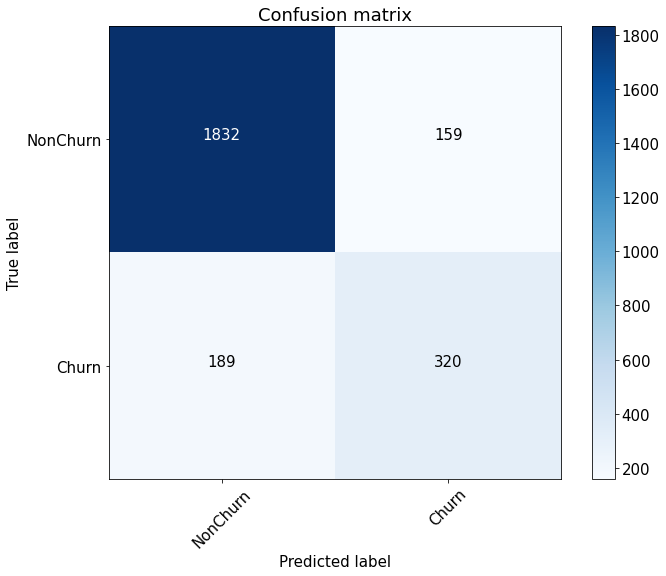

In [88]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Если предположить, что тратя на удержание каждого клиента 1 доллар и зарабатывая с каждого удержанного 2, тогда:
наша модель пытается удержать 1832 + 159(TP + FP) = 1991 человека, затрачивая 1991 доллар в сумме, из них 159 - это люди, которые точно не останутся, а оставшиеся 1832 принесут 2 доллара, таким образом выручка составит 1832 * 2 = 3664 а чистая прибыль 3664 - 1991 = 1673 доллара. Из этого я делаю вывод, что модель экономически целесообразна.

<a name="task4"></a>
### Задание 4

(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

**Пример с перебором параметров с помощью GridSearch**

Сетка с параметрами

In [107]:

params={'classifier__num_leaves':[20,40,60,80,100],
        'classifier__min_child_samples':[5,10,15],
        'classifier__max_depth':[-1,5,10,20],
        'classifier__learning_rate':[0.05,0.1,0.2],
        'classifier__reg_alpha':[0,0.01,0.03]
        }

Запускаем перебор

In [108]:
grid = GridSearchCV(main_model,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': -1,
 'classifier__min_child_samples': 5,
 'classifier__num_leaves': 20,
 'classifier__reg_alpha': 0}

Обучаем модель уже сновыми параметрами

In [109]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(learning_rate=0.05, max_depth=-1, 
                                  min_child_samples=5, num_leaves=20, reg_alpha=0, random_state = 42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

<a name="task5"></a>
### Задание 5

(опционально) Еще раз провести оценку экономической эффективности

Best Threshold=0.310142, F-Score=0.645, Precision=0.608, Recall=0.688
Confusion matrix, without normalization
[[1765  226]
 [ 160  349]]


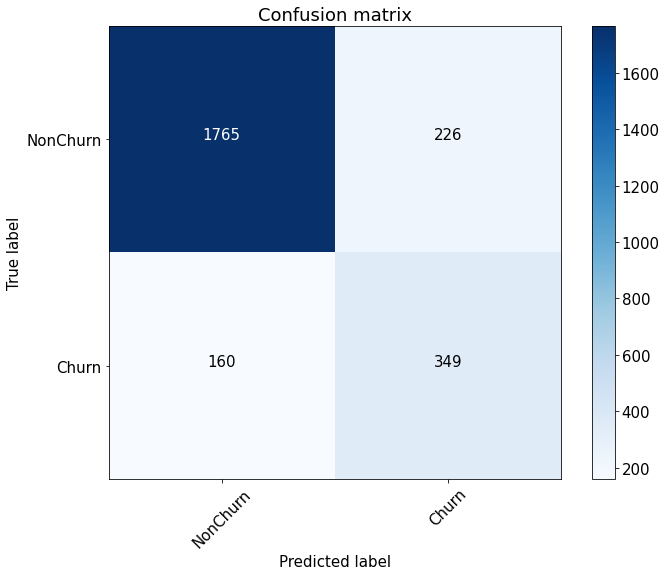

In [110]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Если предположить, что тратя на удержание каждого клиента 1 доллар и зарабатывая с каждого удержанного 2, тогда:
наша модель пытается удержать 1765 + 226(TP + FP) = 1991 человека, затрачивая 1991 доллар в сумме, из них 226 - это люди, которые точно не останутся, а оставшиеся 1765 принесут 2 доллара, таким образом выручка составит 1765 * 2 = 3530 а чистая прибыль 3530 - 1991 = 1539 доллара. **Эта модель хуже предыдущей** но она все еще выгодна, из этого я делаю вывод, что модель экономически целесообразна.